In [1]:
import pandas as pd
import utils
import plotly.express as px

In this notebook, we calculate the mean average precision to identify replicable perturbations and then for retrieving gene-compound pairs. The following steps are taken.
1. Normalized, feature selected compound profiles for replicate plates are merged into a single data frame.
2. Empty wells are removed from all the compound plates.
3. mAP is calculated for compound replicate retrieval (replicability). mAP for a random baseline is subtracted.
4. Negcon wells are removed from the compounds plates.
5. Median consensus profiles are created for all compounds.
6. Non-replicable perturbations are removed (mean AP ≤ 0)
7. Additional target annotations are added to the compound profiles.
8. mAP is calculated for compound-compound pair retrieval (those targeting the same gene). mAP for a random baseline is subtracted.
9. Tables of mAP values are printed and bar plots of mAP values are plotted.

In [2]:
replicability_ap_df = pd.DataFrame()
matching_ap_df = pd.DataFrame()

feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

plates = ['BR00117015', 'BR00117016', 'BR00117017', 'BR00117019']

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
all_plates_df = pd.DataFrame()

for plate in plates:
    data_df = (
        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
        )
    all_plates_df = utils.concat_profiles(all_plates_df, data_df)

# Set Metadata_broad_sample value to "DMSO" for DMSO wells
all_plates_df[feature_to_group_by].fillna("DMSO", inplace=True)

# Remove empty wells
all_plates_df = utils.remove_empty_wells(all_plates_df)

# Description
description = f'compound plate'

# Calculate replicability mAP
print(f'Computing {description} replicability')
precision = utils.PrecisionScores(all_plates_df, all_plates_df, feature_to_group_by, "replicability", "Metadata_broad_sample", within=True, against_negcon=True)

replicability_ap_df = precision.ap_group
replicability_map = precision.map

# Remove DMSO wells
all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

# Create consensus profiles
all_plates_consensus_df = utils.consensus(all_plates_df, feature_to_group_by)

# Filter out non-replicable compounds
replicable_compounds = list(replicability_ap_df[replicability_ap_df.ap>0][feature_to_group_by])
all_plates_consensus_df = all_plates_consensus_df.query('Metadata_broad_sample==@replicable_compounds').reset_index(drop=True)

# Adding additional gene annotation metadata
all_plates_consensus_df = (
    all_plates_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
)

# Expand compound profiles and add new matching_target column
all_plates_consensus_expanded_df = (
    all_plates_consensus_df.assign(Metadata_matching_target= lambda x: x.Metadata_target_list.str.split('|'))
    .explode('Metadata_matching_target')
    .reset_index(drop=True)
)
all_plates_consensus_df = all_plates_consensus_df.assign(Metadata_matching_target=lambda x: x.Metadata_target_list)

# Calculate compound-compound matching
print(f'Computing {description} biological consistency')
precision = utils.PrecisionScores(all_plates_consensus_expanded_df, all_plates_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample", within=True, anti_correlation=True)

matching_ap_df = precision.ap_group
matching_map = precision.map
    

Computing compound plate replicability
Computing compound plate biological consistency


In [4]:
print(f'Replicability mAP = {replicability_map: .3f}')
print(f'Biological consistency mAP = {matching_map: .3f}')

Replicability mAP =  0.699
Biological consistency mAP =  0.124


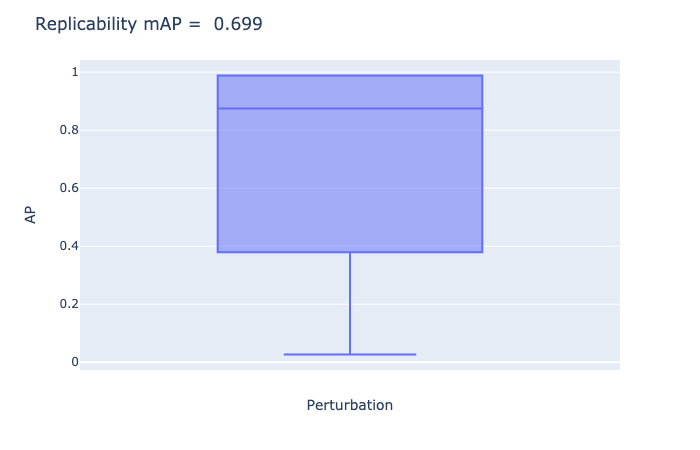

In [5]:
fig = px.box(data_frame=replicability_ap_df,
                y='ap')
fig.update_layout(title=f"Replicability mAP = {replicability_map: .3f}",
                  xaxis=dict(title='Perturbation'),
                  yaxis=dict(title='AP'))
fig.show("png")
fig.write_image(f'figures/0.replicability_ap.png', width=640, height=480, scale=2)

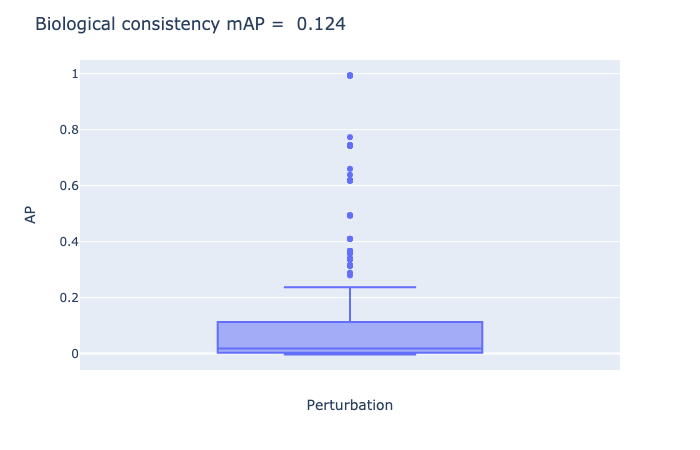

In [6]:
fig = px.box(data_frame=matching_ap_df,
                y='ap',)
fig.update_layout(title=f"Biological consistency mAP = {matching_map: .3f}",
                  xaxis=dict(title='Perturbation'),
                  yaxis=dict(title='AP'))
fig.show("png")
fig.write_image(f'figures/0.biologial_consistency_ap.png', width=640, height=480, scale=2)

In [7]:
replicability_ap_df.to_csv('output/0.replicability_ap.csv', index=False)
matching_ap_df.to_csv('output/0.biological_consistency_ap.csv', index=False)